In [5]:
! pip install polars
! pip install -e ../client

# BastionLab Analytics Demo

BastionLab allows data scientists to run queries on data frames remotely without seeing the original data or intermediary results.
The user uses polars' lazy API augmented with BasionLab's objects to define a *Composite Plan* which is an abstract object representing all the instructions to be run on the server in a lazy fashion. BastionLab's *Composite Plan* supports most polars operations from selects to groupbys to joins.

We intentionnaly forbid map operations with user defined functions to avoid remote code execution. As a replacement, we provide the `apply_udf` method on our `RemoteLazyFrame` type that allows the user to apply a custom TorchScript compatible function on a subset of series. Internally, the provided plain python function is compiled into TorchScript and applied on the server to the matching series by casting them as libtorch tensors.

## Data Loading

!! Pre-requisite : download the train.csv dataset from: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/data and save it in this directory

We load the csv dataset as a plain polars dataframe, we open a connection to the server and we upload the data frame.
The server sends back some metadata (a reference and the schema of the data frame) that are wrapped in a `FetchableLazyFrame`.
`FetchableLazyFrame`s are a subtype of `RemoteLazyFrames` that can be used not only to define the computation graph by using polars' lazy API but also to retrieve the data (we'll add a mechanism to enforce security and privacy rules in the future).

In [6]:
import polars as pl
from bastionlab import Connection

df = pl.read_csv("train.csv").limit(50)

connection = Connection("localhost", 50056)
client = connection.client

rdf = client.send_df(df)

rdf

FetchableLazyFrame(identifier=88418aa0-7a4c-40b1-85f8-c47cd1c2095d)

The `RemoteLazyFrame`s (and their subtypes) can be used to query the metadata without performing any actual request to the server.

In [7]:
rdf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

The user may also invoke polars' lazy API to construct query plans.

In the following cell, we compute the survival rates of the passengers of the Titanic with respect to their ticket class.

Note that issuing such aggregated queries without seing the original dataset or intermediary results already provides some sense of privacy. We plan to add a budgeting mechanism such as Differential Privacy to allow the data owner to control how their data can be used.

In [8]:
per_class_rates = (
    rdf.select([pl.col("Pclass"), pl.col("Survived")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
    .fetch()
)

per_class_rates

Pclass,Survived
i64,f64
2,0.625
1,0.5
3,0.375


We can do the same with respect to the sex of the passengers.

In [9]:
per_sex_rates = (
    rdf.select([pl.col("Sex"), pl.col("Survived")])
    .groupby(pl.col("Sex"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
    .fetch()
)

per_sex_rates

Sex,Survived
str,f64
"""female""",0.72
"""male""",0.16


Aggregated queries may be used locally to make plots

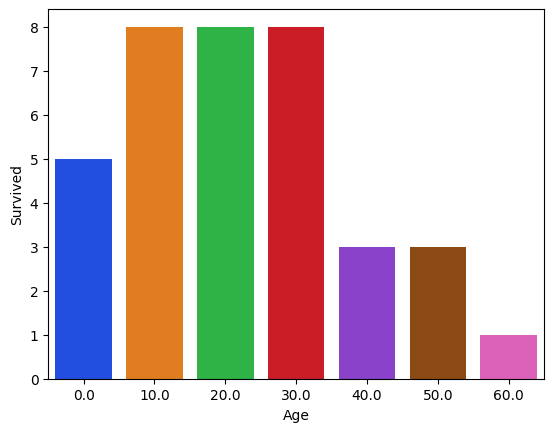

In [10]:
rdf.histplot("Age", "Survived", bins=10, palette="bright")

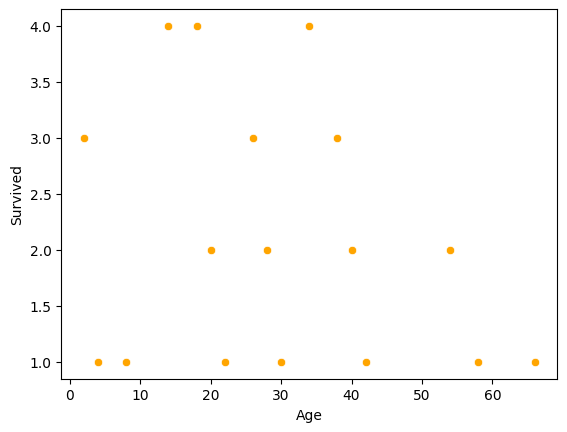

In [11]:
rdf.scatterplot("Age", "Survived", bins=2, color="orange")

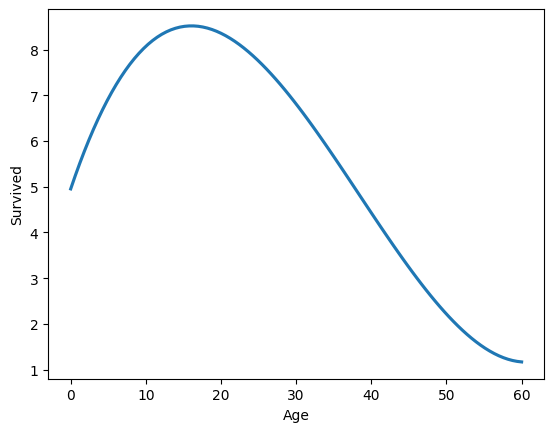

In [12]:
rdf.curveplot(col_x="Age", col_y="Survived", bins=10)

We finally close the conection to the server.

In [13]:
connection.close()